In [ ]:
# Import pandas, numpy, sklearn, matplotlib, and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
convabuse = pd.read_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/convabuse_cleaned1.csv")
dynamically_generated_hate_speech = pd.read_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/dynamically_generated_hate_speech_dataset_cleaned1.csv")
online_abusive_attacks = pd.read_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/online_abusive_attacks_cleaned1.csv")
us_elections_2020_hate_speech = pd.read_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/us_elections_2020_hate_speech_cleaned1.csv")
mlma_hate_speech = pd.read_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/MLMA_hate_speech_cleaned1.csv")

In [ ]:
def calc_mahalanobis(data):
  # Only select numerical features
  numeric_data = data.select_dtypes(include="number")
  # Drop columns with zero variance
  numeric_data = numeric_data.loc[:, numeric_data.var() != 0]
  mean_vector = np.mean(numeric_data, axis=0)
  covariance_matrix = np.cov(numeric_data, rowvar=False)
  # Add a small value to the diagonal for regularization
  reg_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
  inv_covariance_matrix = np.linalg.inv(reg_covariance_matrix)
  mahalanobis_distances = []
  for i in range(len(numeric_data)):
    distance = mahalanobis(numeric_data.iloc[i], mean_vector, inv_covariance_matrix)
    mahalanobis_distances.append(distance)
  sns.histplot(mahalanobis_distances, kde=True)
  plt.title('Distribution of Mahalanobis Distances')
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Frequency')
  plt.show()
  return mahalanobis_distances

In [ ]:
# Choose corresponding indices in convabuse associated with a mahalanobis distance of 10 or above
def get_inliers(data, mahalanobis_distances, threshold):
  inlier_indices = np.where(np.array(mahalanobis_distances) < threshold)[0]
  inliers = data.iloc[inlier_indices]
  print(f"{len(inliers)} total entries after outlier removal vs {len(data)} total entries before outlier removal.")

  sns.histplot(mahalanobis_distances, kde=True)
  plt.title('Distribution of Mahalanobis Distances')
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Frequency')
  plt.show()

  inlier_mahalanobis_distances = [mahalanobis_distances[i] for i in inlier_indices]
  sns.histplot(inlier_mahalanobis_distances, kde=True)
  plt.title('Distribution of Inlier Mahalanobis Distances')
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Frequency')
  plt.show()
  return inliers

# Convabuse Dataset

In [ ]:
# Preview convabuse
convabuse.head()

,example_no,annotator_id,bot,Not Abusive,Ambiguous,Abusive,Very Abusive,Very Strongly Abusive,ableism,homophobic,intellectual,racist,sexist,sex_harassment,transphobic,generalised,individual,system,explicit,implicit
0,0,7,E.L.I.Z.A.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,E.L.I.Z.A.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,7,E.L.I.Z.A.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,7,CarbonBot,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,7,E.L.I.Z.A.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create an "abuse_level" column with default values of 0
convabuse['abuse_level'] = 0

In [ ]:
convabuse.head()

,example_no,annotator_id,bot,Not Abusive,Ambiguous,Abusive,Very Abusive,Very Strongly Abusive,ableism,homophobic,...,racist,sexist,sex_harassment,transphobic,generalised,individual,system,explicit,implicit,abuse_level
0,0,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,E.L.I.Z.A.,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,7,CarbonBot,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Reassign the abuse_level column
not_abusive = convabuse[convabuse['Not Abusive'] == 1]
not_abusive['abuse_level'] = 0
ambiguous = convabuse[convabuse['Ambiguous'] == 1]
ambiguous['abuse_level'] = 1
abusive = convabuse[convabuse['Abusive'] == 1]
abusive['abuse_level'] = 2
very_abusive = convabuse[convabuse['Very Abusive'] == 1]
very_abusive['abuse_level'] = 3
very_strongly_abusive = convabuse[convabuse['Very Strongly Abusive'] == 1]
very_strongly_abusive['abuse_level'] = 4

# Merge all rows and sort by example_no
convabuse = pd.concat([not_abusive, ambiguous, abusive, very_abusive, very_strongly_abusive])
convabuse = convabuse.sort_values(by='example_no')

/tmp/ipython-input-2803096735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_abusive['abuse_level'] = 0
/tmp/ipython-input-2803096735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ambiguous['abuse_level'] = 1
/tmp/ipython-input-2803096735.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
convabuse.tail(20)

,example_no,annotator_id,bot,Not Abusive,Ambiguous,Abusive,Very Abusive,Very Strongly Abusive,ableism,homophobic,...,racist,sexist,sex_harassment,transphobic,generalised,individual,system,explicit,implicit,abuse_level
12748,12748,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12749,12749,4,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12750,12750,4,E.L.I.Z.A.,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,1,0,4
12751,12751,4,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12752,12752,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12753,12753,4,CarbonBot,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12754,12754,4,CarbonBot,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12755,12755,7,E.L.I.Z.A.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12756,12756,5,E.L.I.Z.A.,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,3
12757,12757,4,E.L.I.Z.A.,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,3


In [ ]:
# Drop the abuse level columns as they are no longer needed
convabuse = convabuse.drop(columns=['Not Abusive', 'Ambiguous', 'Abusive', 'Very Abusive', 'Very Strongly Abusive'])
convabuse.head()

,example_no,annotator_id,bot,ableism,homophobic,intellectual,racist,sexist,sex_harassment,transphobic,generalised,individual,system,explicit,implicit,abuse_level
0,0,7,E.L.I.Z.A.,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,E.L.I.Z.A.,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,7,E.L.I.Z.A.,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,7,CarbonBot,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,7,E.L.I.Z.A.,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
convabuse["abuse_level"].value_counts()

,count
abuse_level,
0,10068
3,934
2,813
1,671
4,282


In [ ]:
# Rename racism to race_or_ethnicity
convabuse = convabuse.rename(columns={'racist': 'race_or_ethnicity'})

# If 1 in either homophobic or transphobic, assign 1 to lgbtq, otherwise, assign 0 to lgbtq
convabuse['lgbtq'] = np.where((convabuse['homophobic'] == 1) | (convabuse['transphobic'] == 1), 1, 0)

# If 1 in either sexist or sex_harassment, assign 1 to gender, otherwise, assign 0 to gender
convabuse['gender'] = np.where((convabuse['sexist'] == 1) | (convabuse['sex_harassment'] == 1), 1, 0)

# If 1 in either  ableism or intellectual, assign 1 to disability, otherwise, assign 0 to disability
convabuse['disability'] = np.where((convabuse['ableism'] == 1) | (convabuse['intellectual'] == 1), 1, 0)

# Remove the other redundant columns
convabuse = convabuse.drop(columns=['sexist', 'transphobic', 'sexist', 'sex_harassment', 'ableism', 'intellectual'])

# Assign 0 columns for religion, nationality, age, class, and none
convabuse['religion'] = 0
convabuse['nationality'] = 0
convabuse['age'] = 0
convabuse['class'] = 0
convabuse['none'] = 0

# Rearrange the convabuse columns
convabuse = convabuse[['example_no', 'annotator_id', 'bot', 'race_or_ethnicity', 'gender', 'religion', 'lgbtq', 'nationality', 'age', 'disability', 'class', 'none', 'abuse_level']]

In [ ]:
# Drop example_no and annotator_id
convabuse = convabuse.drop(columns=["example_no", "annotator_id", "bot"])

## Convabuse Outlier Detection

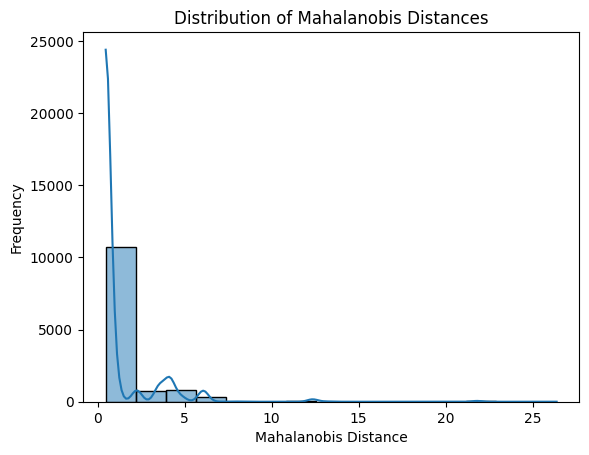

In [ ]:
convabuse_mahalanobis_distances = calc_mahalanobis(convabuse)

12659 total entries after outlier removal vs 12768 total entries before outlier removal.


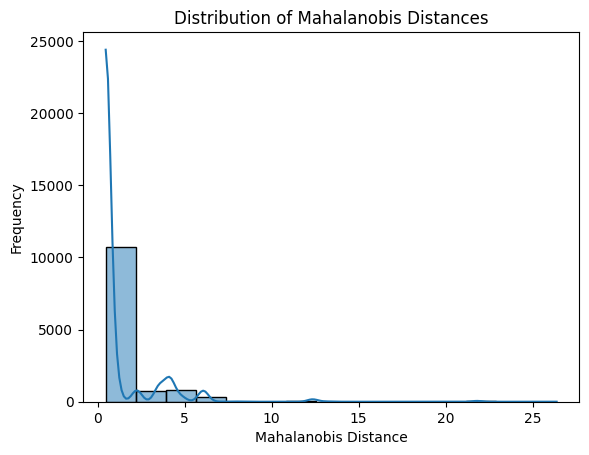

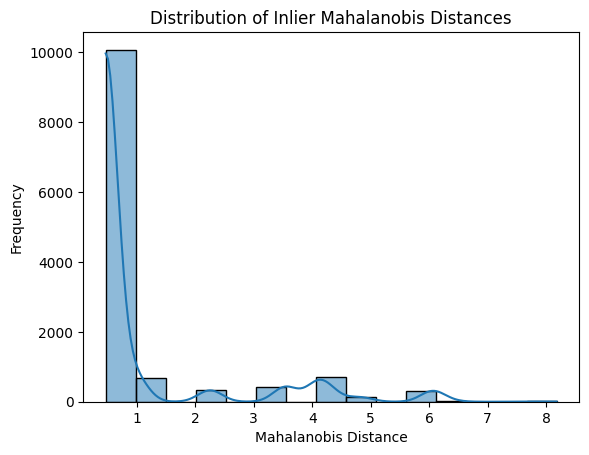

In [ ]:
convabuse_inliers = get_inliers(convabuse, convabuse_mahalanobis_distances, 10)

## Convabuse Rebalanced

In [ ]:
convabuse_imbalanced = convabuse_inliers

In [ ]:
convabuse_imbalanced["abuse_level"].value_counts()

,count
abuse_level,
0,10068
3,897
2,773
1,671
4,250


In [ ]:
# Resample 0 as the majority class and 1, 2, 3, and 4 as the minority classes in the abuse_level column
convabuse_majority_y = convabuse_imbalanced[convabuse_imbalanced["abuse_level"] == 0]
convabuse_minority_y1 = convabuse_imbalanced[convabuse_imbalanced["abuse_level"] == 1]
convabuse_minority_y2 = convabuse_imbalanced[convabuse_imbalanced["abuse_level"] == 2]
convabuse_minority_y3 = convabuse_imbalanced[convabuse_imbalanced["abuse_level"] == 3]
convabuse_minority_y4 = convabuse_imbalanced[convabuse_imbalanced["abuse_level"] == 4]

# Upsample the minority classes
convabuse_minority_y1_upsampled = resample(convabuse_minority_y1,random_state=42,n_samples=(len(convabuse_majority_y)),replace=True)
convabuse_minority_y2_upsampled = resample(convabuse_minority_y2,random_state=42,n_samples=(len(convabuse_majority_y)),replace=True)
convabuse_minority_y3_upsampled = resample(convabuse_minority_y3,random_state=42,n_samples=(len(convabuse_majority_y)),replace=True)
convabuse_minority_y4_upsampled = resample(convabuse_minority_y4,random_state=42,n_samples=(len(convabuse_majority_y)),replace=True)

In [ ]:
#concatenate the upsampled dataframe
convabuse_upsampled = pd.concat([convabuse_majority_y, convabuse_minority_y1_upsampled, convabuse_minority_y2_upsampled, convabuse_minority_y3_upsampled, convabuse_minority_y4_upsampled]).reset_index()
convabuse_upsampled

,index,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none,abuse_level
0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
50335,9591,0,0,0,0,0,0,0,0,0,4
50336,4529,0,1,0,0,0,0,0,0,0,4
50337,2305,0,0,0,0,0,0,0,0,0,4
50338,1731,0,1,0,0,0,0,0,0,0,4


In [ ]:
convabuse_upsampled["abuse_level"].value_counts()

,count
abuse_level,
0,10068
1,10068
2,10068
3,10068
4,10068


In [ ]:
convabuse_upsampled = convabuse_upsampled.drop(columns=['index'])

In [ ]:
convabuse_upsampled["abuse_level"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
convabuse_upsampled.head()

,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none,abuse_level
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
convabuse_upsampled.shape

(50340, 10)

In [ ]:
convabuse = convabuse_upsampled

In [ ]:
# Output the convabuse dataframe as a csv file
convabuse.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/convabuse_final.csv", index=False)
convabuse_imbalanced.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/convabuse_imbalanced.csv", index=False)

# Dynamically Generated Hate Speech Dataset

In [ ]:
# Preview dynamically_generated_hate_speech
dynamically_generated_hate_speech.head()

,label,type,level,annotator,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none
0,1.0,0,original,3,0,0,0,0,0,0,0,0,1
1,1.0,0,original,3,0,0,0,0,0,0,0,0,1
2,1.0,0,original,18,0,0,0,0,0,0,0,0,1
3,1.0,0,original,16,0,0,0,0,0,0,0,0,1
4,1.0,0,original,7,0,0,0,0,0,0,0,0,1


In [ ]:
dynamically_generated_hate_speech["type"].value_counts()

,count
type,
0,26079
-1,14858
1,89


In [ ]:
dynamically_generated_hate_speech["label"].value_counts()

,count
label,
1.0,22057
0.0,18969


In [ ]:
# Drop annotator
dynamically_generated_hate_speech = dynamically_generated_hate_speech.drop("annotator", axis=1)

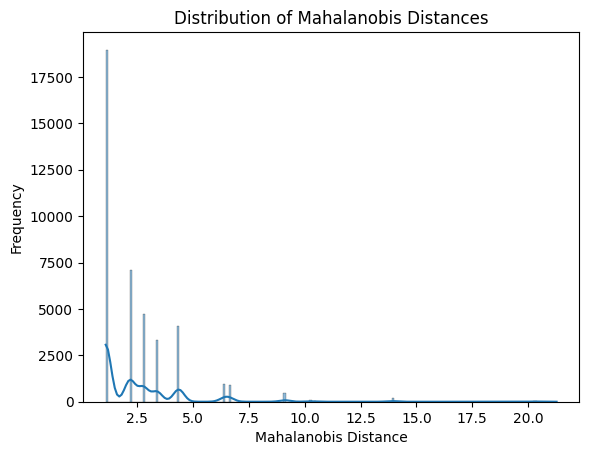

In [ ]:
dghs_mahalanobis_distances = calc_mahalanobis(dynamically_generated_hate_speech)

40611 total entries after outlier removal vs 41026 total entries before outlier removal.


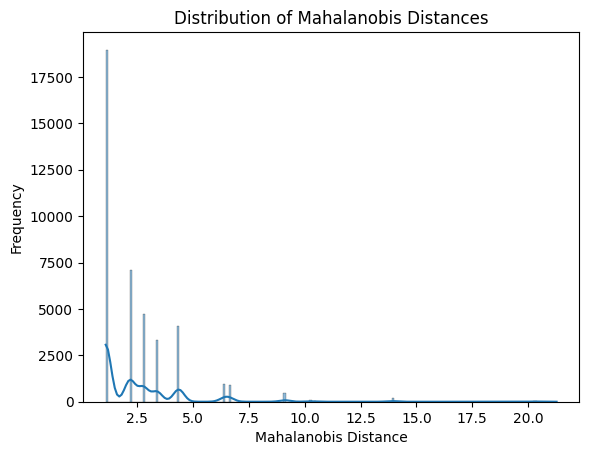

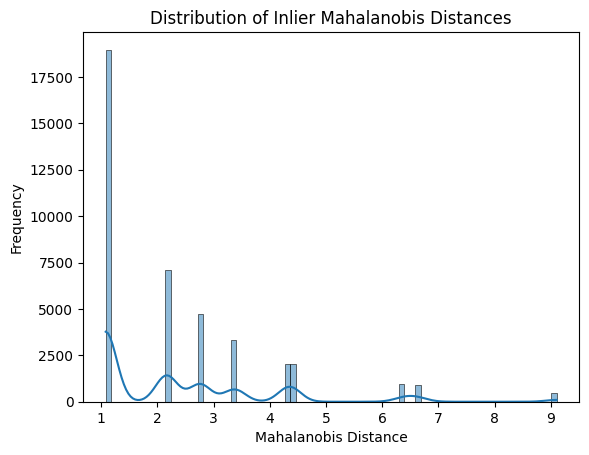

In [ ]:
dghs_inliers = get_inliers(dynamically_generated_hate_speech, dghs_mahalanobis_distances, 10)

In [ ]:
dynamically_generated_hate_speech_imbalanced = dghs_inliers

In [ ]:
# Resample 0 as the majority class and 1 as the minority class in the label column

#set the minority class to a separate dataframe
dynamically_generated_hate_speech_minority_y = dynamically_generated_hate_speech_imbalanced[dynamically_generated_hate_speech_imbalanced['label'] == 1]
#set other classes to another dataframe
dynamically_generated_hate_speech_majority_y = dynamically_generated_hate_speech_imbalanced[dynamically_generated_hate_speech_imbalanced['label'] == 0]
#upsample the minority class
dynamically_generated_hate_speech_minority_y_upsampled = resample(dynamically_generated_hate_speech_minority_y,random_state=42,n_samples=(len(dynamically_generated_hate_speech_majority_y)),replace=True)

In [ ]:
#concatenate the upsampled dataframe
dynamically_generated_hate_speech_upsampled = pd.concat([dynamically_generated_hate_speech_minority_y_upsampled, dynamically_generated_hate_speech_majority_y]).reset_index()
dynamically_generated_hate_speech_upsampled

,index,label,type,level,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none
0,31447,1.0,-1,perturbation,0,0,0,1,0,0,0,0,0
1,1352,1.0,-1,original,0,0,0,0,0,0,0,0,0
2,10632,1.0,-1,perturbation,0,0,0,0,0,0,0,0,0
3,40942,1.0,0,original,0,0,0,0,0,0,0,0,1
4,23570,1.0,-1,original,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37933,41000,0.0,0,original,0,0,0,0,0,0,0,0,1
37934,41016,0.0,0,original,0,0,0,0,0,0,0,0,1
37935,41020,0.0,0,original,0,0,0,0,0,0,0,0,1
37936,41023,0.0,0,original,0,0,0,0,0,0,0,0,1


In [ ]:
dynamically_generated_hate_speech_upsampled['label'].value_counts()

,count
label,
1.0,18969
0.0,18969


In [ ]:
dynamically_generated_hate_speech_upsampled = dynamically_generated_hate_speech_upsampled.drop(columns=['index'])

In [ ]:
dynamically_generated_hate_speech_upsampled.head()

,label,type,level,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none
0,1.0,-1,perturbation,0,0,0,1,0,0,0,0,0
1,1.0,-1,original,0,0,0,0,0,0,0,0,0
2,1.0,-1,perturbation,0,0,0,0,0,0,0,0,0
3,1.0,0,original,0,0,0,0,0,0,0,0,1
4,1.0,-1,original,0,0,0,0,0,0,0,0,0


In [ ]:
dynamically_generated_hate_speech_upsampled["level"].unique()

In [ ]:
# Rename level to original, then reassign 1 to "original" values and 0 to "perturbation"
dynamically_generated_hate_speech_upsampled["original"] = dynamically_generated_hate_speech_upsampled["level"]
dynamically_generated_hate_speech_imbalanced["original"] = dynamically_generated_hate_speech_imbalanced["level"]

In [ ]:
# Replace "original" with 1 and "perturbation" with 0
dynamically_generated_hate_speech_upsampled["original"] = dynamically_generated_hate_speech_upsampled["original"].replace({"original": 1, "perturbation": 0})
dynamically_generated_hate_speech_imbalanced["original"] = dynamically_generated_hate_speech_imbalanced["original"].replace({"original": 1, "perturbation": 0})

/tmp/ipython-input-155411668.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dynamically_generated_hate_speech_upsampled["original"] = dynamically_generated_hate_speech_upsampled["original"].replace({"original": 1, "perturbation": 0})
/tmp/ipython-input-155411668.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dynamically_generated_hate_speech_imbalanced["original"] = dynamically_generated_hate_speech_imbalanced["original"].replace({"original": 1, "perturbation": 0})
/tmp/ipython-input-155411668.py:3: SettingWithCopyWarnin

In [ ]:
dynamically_generated_hate_speech_upsampled["original"].unique()

array([0, 1])

In [ ]:
# Drop the level column
dynamically_generated_hate_speech_upsampled = dynamically_generated_hate_speech_upsampled.drop(columns=['level'])
dynamically_generated_hate_speech_imbalanced = dynamically_generated_hate_speech_imbalanced.drop(columns=['level'])

In [ ]:
dynamically_generated_hate_speech_upsampled.head()

,label,type,race_or_ethnicity,gender,religion,lgbtq,nationality,age,disability,class,none,original
0,1.0,-1,0,0,0,1,0,0,0,0,0,0
1,1.0,-1,0,0,0,0,0,0,0,0,0,1
2,1.0,-1,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,1,1
4,1.0,-1,0,0,0,0,0,0,0,0,0,1


In [ ]:
dynamically_generated_hate_speech = dynamically_generated_hate_speech_upsampled

In [ ]:
# Output dynamically_generated_hate_speech to a csv file
dynamically_generated_hate_speech.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/dynamically_generated_hate_speech_dataset_final.csv", index=False)
dynamically_generated_hate_speech_imbalanced.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/dynamically_generated_hate_speech_dataset_imbalanced.csv", index=False)

# Online Abusive Attacks

In [ ]:
online_abusive_attacks.head()

,verified,high Identity_Attack,high Insult,high Profanity,high Threat,high other attr,Toxicity
0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2.0,0.0,10.0,0.0,0.0,1.0
2,0,17.0,1.0,25.0,1.0,0.0,1.0
3,0,9.0,2.0,33.0,2.0,0.0,3.0
4,0,0.0,0.0,7.0,0.0,0.0,0.0


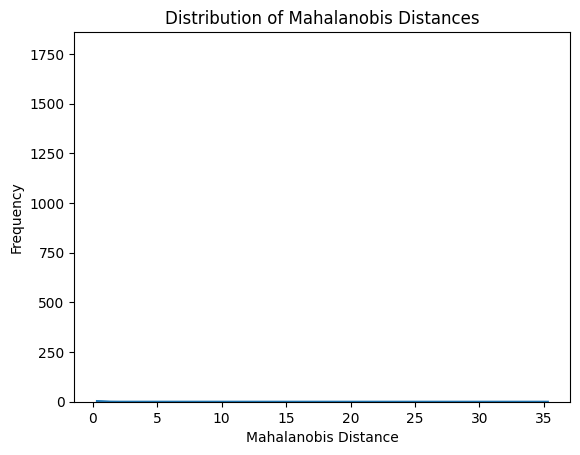

In [ ]:
online_abusive_attacks_mahalanobis_distances = calc_mahalanobis(online_abusive_attacks)

1946 total entries after outlier removal vs 2365 total entries before outlier removal.


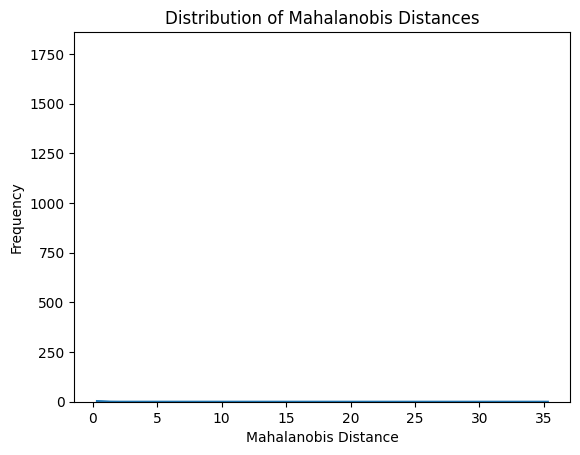

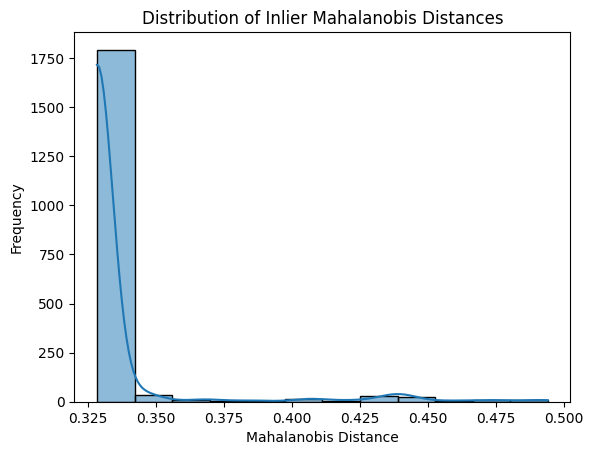

In [ ]:
online_abusive_attacks_inliers = get_inliers(online_abusive_attacks, online_abusive_attacks_mahalanobis_distances, 0.5)

In [ ]:
online_abusive_attacks_inliers["Toxicity"].value_counts()

,count
Toxicity,
0.0,1937
1.0,9


In [ ]:
# Output online_abusive_attacks_hate_speech to a csv file
online_abusive_attacks.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/online_abusive_attacks_final.csv", index=False)

# Hate Speech 2020 US Elections Dataset

In [ ]:
us_elections_2020_hate_speech.head()

,Trump,Biden,HOF
0,0.0,4.0,Non-Hateful
1,0.0,4.0,Non-Hateful
2,1.0,2.0,Non-Hateful
3,4.0,2.0,Non-Hateful
4,2.0,0.0,Non-Hateful


In [ ]:
us_elections_2020_hate_speech['HOF'].unique()

array(['Non-Hateful', 'Hateful'], dtype=object)

In [ ]:
# Replace values of "Non-Hateful" with 0 and values of "Hateful" with 1
us_elections_2020_hate_speech['HOF'] = us_elections_2020_hate_speech['HOF'].replace({'Non-Hateful': 0, 'Hateful': 1})

/tmp/ipython-input-2594426102.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  us_elections_2020_hate_speech['HOF'] = us_elections_2020_hate_speech['HOF'].replace({'Non-Hateful': 0, 'Hateful': 1})


In [ ]:
# View the distribution of HOF values
us_elections_2020_hate_speech['HOF'].value_counts()

,count
HOF,
0,2648
1,352


In [ ]:
us2020hs_mahalanobis_distances = calc_mahalanobis(us_elections_2020_hate_speech)

In [ ]:
us_elections_inliers = get_inliers(us_elections_2020_hate_speech, us2020hs_mahalanobis_distances, 3.5)

In [ ]:
us_elections_inliers["HOF"].value_counts()

In [ ]:
us_elections_2020_hate_speech_imbalanced = us_elections_inliers

In [ ]:
# Resample 0 as the majority class and 1 as the minority class in the HOF column

#set the minority class to a seperate dataframe
us_elections_2020_hate_speech_minority_y = us_elections_2020_hate_speech_imbalanced[us_elections_2020_hate_speech_imbalanced['HOF'] == 1]
#set other classes to another dataframe
us_elections_2020_hate_speech_majority_y = us_elections_2020_hate_speech_imbalanced[us_elections_2020_hate_speech_imbalanced['HOF'] == 0]
#upsample the minority class
us_elections_2020_hate_speech_minority_y_upsampled = resample(us_elections_2020_hate_speech_minority_y,random_state=42,n_samples=(len(us_elections_2020_hate_speech_majority_y)),replace=True)

In [ ]:
#concatenate the upsampled dataframe
us_elections_2020_hate_speech_upsampled = pd.concat([us_elections_2020_hate_speech_minority_y_upsampled, us_elections_2020_hate_speech_majority_y]).reset_index()
us_elections_2020_hate_speech_upsampled

In [ ]:
us_elections_2020_hate_speech_upsampled = us_elections_2020_hate_speech_upsampled.drop("index", axis=1)

In [ ]:
us_elections_2020_hate_speech_upsampled['HOF'].value_counts()

In [ ]:
us_elections_2020_hate_speech = us_elections_2020_hate_speech_upsampled

In [ ]:
# Output the us_elections_2020_hate_speech dataset
us_elections_2020_hate_speech.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/us_elections_2020_hate_speech_final.csv", index=False)
us_elections_2020_hate_speech_imbalanced.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/us_elections_2020_hate_speech_imbalanced.csv", index=False)

# MLMA Hate Speech Dataset

In [ ]:
mlma_hate_speech.head()

In [ ]:
mlma_hate_speech['abuse_level'].unique()

In [ ]:
# View the distribution of HOF values
mlma_hate_speech['abuse_level'].value_counts()

In [ ]:
# Drop HITId
mlma_hate_speech = mlma_hate_speech.drop("HITId", axis=1)

In [ ]:
mlma_hate_speech_mahalanobis_distances = calc_mahalanobis(mlma_hate_speech)

In [ ]:
mlma_hate_speech_inliers = get_inliers(mlma_hate_speech, mlma_hate_speech_mahalanobis_distances, 6)

In [ ]:
# View the distribution of HOF values
mlma_hate_speech_inliers['abuse_level'].value_counts()

In [ ]:
mlma_hate_speech_imbalanced = mlma_hate_speech_inliers

In [ ]:
# Resample 0 as the majority class and 1 as the minority class in the HOF column

# Set the majority class
mlma_hate_speech_majority_y = mlma_hate_speech_imbalanced[mlma_hate_speech_imbalanced['abuse_level'] == 2]

# Set the minority classes
mlma_hate_speech_minority_y1 = mlma_hate_speech_imbalanced[mlma_hate_speech_imbalanced['abuse_level'] == 3]
mlma_hate_speech_minority_y2 = mlma_hate_speech_imbalanced[mlma_hate_speech_imbalanced['abuse_level'] == 0]
mlma_hate_speech_minority_y3 = mlma_hate_speech_imbalanced[mlma_hate_speech_imbalanced['abuse_level'] == 4]

# upsample the minority classes
mlma_hate_speech_minority_y1_upsampled = resample(mlma_hate_speech_minority_y1,random_state=42,n_samples=(len(mlma_hate_speech_majority_y)),replace=True)
mlma_hate_speech_minority_y2_upsampled = resample(mlma_hate_speech_minority_y2,random_state=42,n_samples=(len(mlma_hate_speech_majority_y)),replace=True)
mlma_hate_speech_minority_y3_upsampled = resample(mlma_hate_speech_minority_y3,random_state=42,n_samples=(len(mlma_hate_speech_majority_y)),replace=True)

In [ ]:
#concatenate the upsampled dataframe
mlma_hate_speech_upsampled = pd.concat([mlma_hate_speech_minority_y2_upsampled, mlma_hate_speech_majority_y, mlma_hate_speech_minority_y1_upsampled, mlma_hate_speech_minority_y3_upsampled]).reset_index()
mlma_hate_speech_upsampled

In [ ]:
mlma_hate_speech_upsampled['abuse_level'].value_counts()

In [ ]:
mlma_hate_speech = mlma_hate_speech_upsampled

In [ ]:
# Output the mlma_hate_speech dataset
mlma_hate_speech.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/MLMA_hate_speech_final.csv", index=False)
mlma_hate_speech.to_csv("/content/drive/MyDrive/Online MSDS/MOD C2/Political Polarization/data/MLMA_hate_speech_imbalanced.csv", index=False)